#### Equal frequency discretisation | Quantile discretization 

Equal frequency discretisation divides the scope of possible values of the variable into N bins, where each bin carries the same amount of observations. This is particularly useful for skewed variables as it spreads the observations over the different bins equally. We find the interval boundaries by determining the quantiles.

Equal frequency discretisation using quantiles consists of dividing the continuous variable into N quantiles, N to be defined by the user.

Equal frequency binning is straightforward to implement and by spreading the values of the observations more evenly it may help boost the algorithm's performance. This arbitrary binning may also disrupt the relationship with the target.


Dataset: Titanic 

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import KBinsDiscretizer

In [3]:
data = pd.read_csv('../datasets/titanic.csv', usecols=['age', 'fare', 'survived'])
data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [4]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0
)

X_train.shape, X_test.shape

((916, 2), (393, 2))

The variables Age and Fare contain missing data, that I will fill by extracting a random sample of the variable.

In [5]:
def impute_na(data, variable):
    # function to fill NA with a random sample

    df = data.copy()

    # random sampling
    df[variable+'_random'] = df[variable]

    # extract the random sample to fill the na
    random_sample = X_train[variable].dropna().sample(
        df[variable].isnull().sum(), random_state=0)

    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample

    return df[variable+'_random']

In [6]:
# replace NA in both train and test sets

X_train['age'] = impute_na(X_train, 'age')
X_test['age'] = impute_na(X_test, 'age')

X_train['fare'] = impute_na(X_train, 'fare')
X_test['fare'] = impute_na(X_test, 'fare')

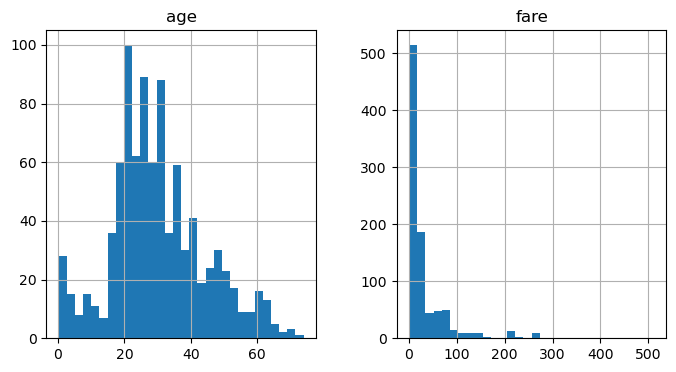

In [7]:
# let's explore the distribution of age

X_train[['age', 'fare']].hist(bins=30, figsize=(8,4))
plt.show()

#### Equal frequency discretisation

In [8]:
# let's use pandas qcut (quantile cut) and I indicate that
# we want 10 bins.

# retbins = True indicates that I want to capture the limits
# of each interval (so I can then use them to cut the test set)

Age_disccretised, intervals = pd.qcut(
    X_train['age'], 10, labels=None, retbins=True, precision=3, duplicates='raise')

pd.concat([Age_disccretised, X_train['age']], axis=1).head(10)

,age,age
501,"(0.166, 16.0]",13.0
588,"(0.166, 16.0]",4.0
402,"(28.0, 31.0]",30.0
1193,"(36.0, 42.0]",40.5
686,"(20.0, 22.0]",22.0
971,"(36.0, 42.0]",39.0
117,"(28.0, 31.0]",30.0
540,"(0.166, 16.0]",2.0
294,"(42.0, 50.0]",49.0
261,"(31.0, 36.0]",35.0


We can see in the above output how by discretising using quantiles, we placed each Age observation within one interval. For example, age 30 was placed in the 28-31 interval, whereas age 49 was placed into the 42-50 interval.

Note how the interval widths are different.

We can see the interval cut points below:

In [9]:
intervals

array([ 0.1667, 16.    , 20.    , 22.    , 25.    , 28.    , 31.    ,
       36.    , 42.    , 50.    , 74.    ])

In [10]:
# roughly the same number of passengers per interval

Age_disccretised.value_counts()

(0.166, 16.0]    106
(31.0, 36.0]     106
(16.0, 20.0]      92
(22.0, 25.0]      92
(25.0, 28.0]      92
(28.0, 31.0]      90
(42.0, 50.0]      90
(36.0, 42.0]      85
(20.0, 22.0]      82
(50.0, 74.0]      81
Name: age, dtype: int64

In [11]:
# we can also add labels instead of having the interval boundaries, to the bins, as follows:

labels = ['Q'+str(i) for i in range(1,11)]
labels

['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10']

In [12]:
Age_disccretised, intervals = pd.qcut(X_train['age'], 10, labels=labels,
                                      retbins=True,
                                      precision=3, duplicates='raise')

Age_disccretised.head()

501     Q1
588     Q1
402     Q6
1193    Q8
686     Q3
Name: age, dtype: category
Categories (10, object): ['Q1' < 'Q2' < 'Q3' < 'Q4' ... 'Q7' < 'Q8' < 'Q9' < 'Q10']

To apply the intervals to the test set, we need to extend the limits of the outer bins to -inf and +inf, so that if in the test set, there are smaller or bigger values than the  minimum or maximum values in the train set, they can be accomodated in the outer intervals. Otherwise, they will be replaced by NaN.

In [13]:
# Prepend/Append infinities to accommodate outliers
intervals[0] = float("-inf")
intervals[len(intervals) - 1] = float("inf")

intervals

array([-inf,  16.,  20.,  22.,  25.,  28.,  31.,  36.,  42.,  50.,  inf])

In [37]:
# to transform the test set:
# we use pandas cut method (instead of qcut) and
# pass the quantile edges calculated in the training set

X_train['Age_disc_label'] = pd.cut(x = X_train['age'], bins=intervals, labels=labels)
X_train['Age_disc'] = pd.cut(x = X_train['age'], bins=intervals)

X_train.head(10)

,age,fare,Age_disc_label,Age_disc
501,13.0,19.5000,Q1,"(-inf, 16.0]"
588,4.0,23.0000,Q1,"(-inf, 16.0]"
402,30.0,13.8583,Q6,"(28.0, 31.0]"
1193,40.5,7.7250,Q8,"(36.0, 42.0]"
686,22.0,7.7250,Q3,"(20.0, 22.0]"
971,39.0,7.8792,Q8,"(36.0, 42.0]"
117,30.0,56.9292,Q6,"(28.0, 31.0]"
540,2.0,26.0000,Q1,"(-inf, 16.0]"
294,49.0,110.8833,Q9,"(42.0, 50.0]"
261,35.0,26.2875,Q7,"(31.0, 36.0]"


In [15]:
# to transform the test set:
# we use pandas cut method (instead of qcut) and
# pass the quantile edges calculated in the training set

X_test['Age_disc_label'] = pd.cut(x = X_test['age'], bins=intervals, labels=labels)
X_test['Age_disc'] = pd.cut(x = X_test['age'], bins=intervals)

X_test.head(10)

,age,fare,Age_disc_label,Age_disc
1139,38.0,7.8958,Q8,"(36.0, 42.0]"
533,21.0,21.0000,Q3,"(20.0, 22.0]"
459,42.0,27.0000,Q8,"(36.0, 42.0]"
1150,3.0,14.5000,Q1,"(-inf, 16.0]"
393,25.0,31.5000,Q4,"(22.0, 25.0]"
1189,4.0,16.7000,Q1,"(-inf, 16.0]"
5,48.0,26.5500,Q9,"(42.0, 50.0]"
231,52.0,30.5000,Q10,"(50.0, inf]"
330,57.0,13.0000,Q10,"(50.0, inf]"
887,31.0,8.1125,Q6,"(28.0, 31.0]"


In [16]:
X_test['Age_disc_label'].isnull().sum()

0

In [28]:
type(X_test['Age_disc'])

pandas.core.series.Series

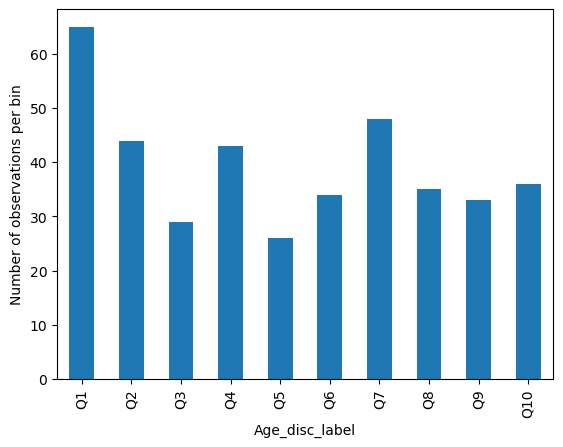

In [31]:
# let's check that we have equal frequency (equal number of observations per bin)
X_test.groupby('Age_disc_label')['age'].count().plot.bar()
plt.xticks(rotation=90)
plt.ylabel('Number of observations per bin')
plt.show()

We can see that the top intervals have less observations. This may happen with skewed distributions if we try to divide in a high number of intervals. To make the value spread more homogeneous, we should discretise in less intervals.

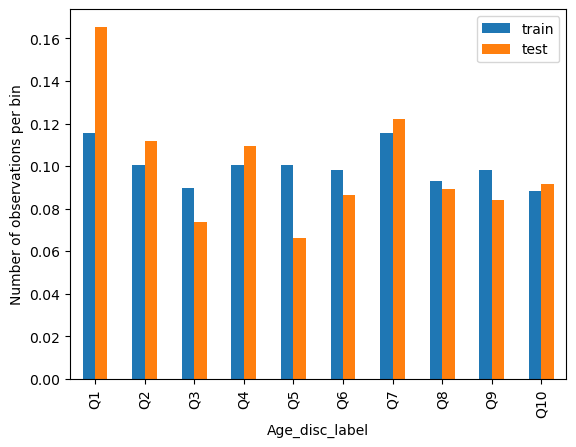

In [38]:
# if the distributions in train and test set are similar, we should expect similar propotion of
# observations in the different intervals in the train and test set
# let's see that below

t1 = X_train.groupby(['Age_disc_label'])['age'].count() / len(X_train)
t2 = X_test.groupby(['Age_disc_label'])['age'].count() / len(X_test)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']

tmp.plot(kind='bar')
plt.xticks(rotation=90)
plt.ylabel('Number of observations per bin')
plt.show()

Equal frequency discretisation Using Scikit-learn

In [39]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

In [40]:
# replace NA in both  train and test sets

X_train['age'] = impute_na(data, 'age')
X_test['age'] = impute_na(data, 'age')

X_train['fare'] = impute_na(data, 'fare')
X_test['fare'] = impute_na(data, 'fare')

In [41]:
disc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

disc.fit(X_train[['age', 'fare']])

KBinsDiscretizer(encode='ordinal', n_bins=10)

In [42]:
disc.bin_edges_

array([array([ 0.1667, 16.    , 20.    , 22.25  , 25.    , 28.    , 31.    ,
              36.    , 42.    , 50.    , 74.    ])                          ,
       array([  0.    ,   7.55  ,   7.7958,   8.05  ,  10.5   ,  14.4542,
               21.075 ,  26.55  ,  40.125 ,  79.025 , 512.3292])         ],
      dtype=object)

In [43]:
train_t = disc.transform(X_train[['age', 'fare']])

train_t = pd.DataFrame(train_t, columns = ['age', 'fare'])

train_t.head()

,age,fare
0,0.0,5.0
1,0.0,6.0
2,5.0,4.0
3,2.0,1.0
4,2.0,1.0


In [44]:
test_t = disc.transform(X_test[['age', 'fare']])

test_t = pd.DataFrame(test_t, columns = ['age', 'fare'])

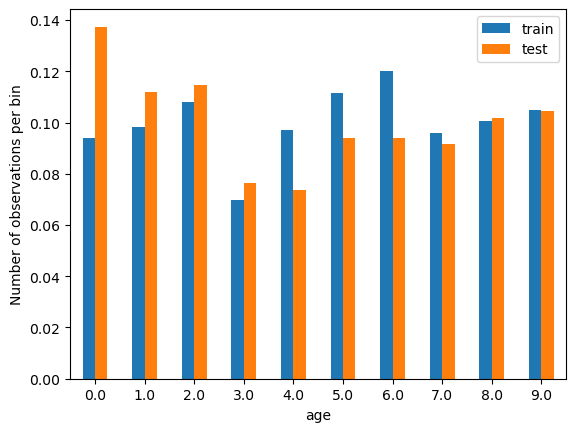

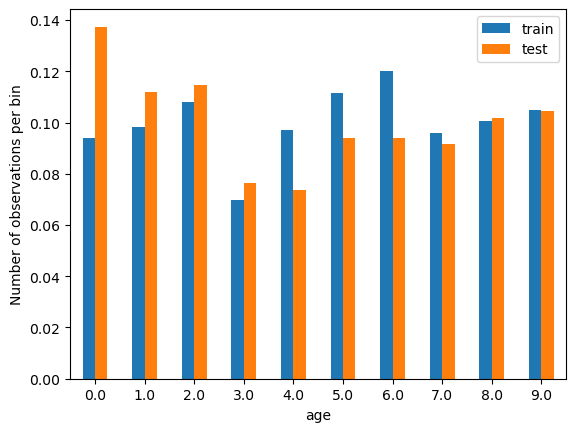

In [46]:
t1 = train_t.groupby(['age'])['age'].count() / len(train_t)
t2 = test_t.groupby(['age'])['age'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')
plt.show()

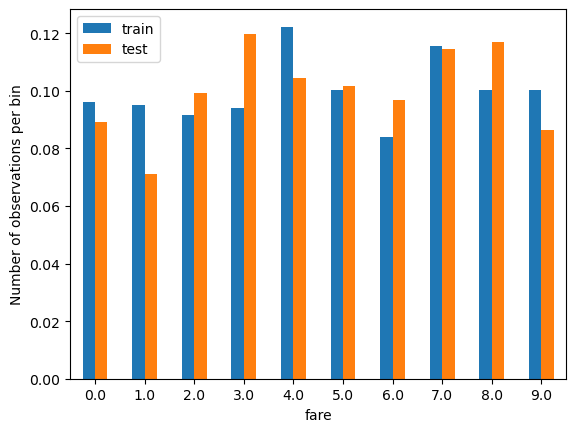

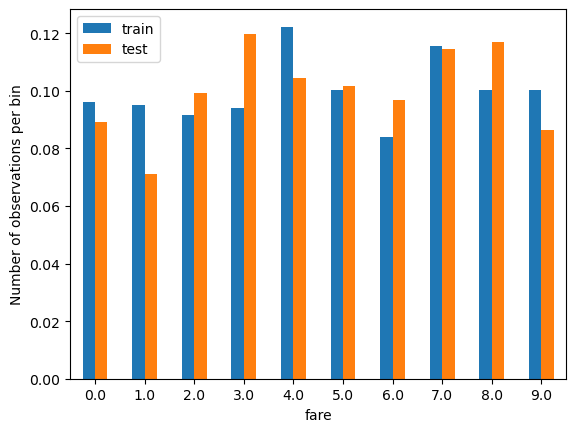

In [48]:
t1 = train_t.groupby(['fare'])['fare'].count() / len(train_t)
t2 = test_t.groupby(['fare'])['fare'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')
plt.show()